# "Diffusion Model Tutorial Using MedNIST dataset"
by Miguel Xochicale 

### History 
* Dec 2022: Prototyped 


## Reference 
> Niels Rogge and Kashif Rasul (Published June 7th, 2022.)   
 https://huggingface.co/blog/annotated-diffusion

 


In [26]:
import os
import math
import time

from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

from PIL import Image
import requests

import torch
import torch.nn.functional as F

from torch import nn, einsum
from torch.utils.data import DataLoader

import torchvision

print(f' torch.cuda.is_available(): {torch.cuda.is_available()}')


 torch.cuda.is_available(): True


In [2]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [4]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [5]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [7]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [8]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [9]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)


# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(640, 427)


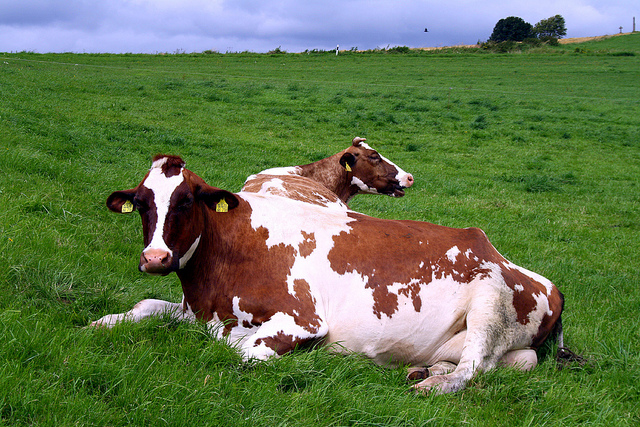

In [10]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'#CATS
# url = 'http://images.cocodataset.org/test-stuff2017/000000000002.jpg'#CAR
url = 'http://images.cocodataset.org/test-stuff2017/000000000019.jpg' #COWS
# url = 'http://images.cocodataset.org/test-stuff2017/000000000128.jpg'#ELEPAHN
# url = 'http://images.cocodataset.org/test-stuff2017/000000000171.jpg' #NEO
# url = 'http://images.cocodataset.org/test-stuff2017/000000000184.jpg' #MAN/APPLE
# url = 'http://images.cocodataset.org/test-stuff2017/000000000300.jpg' #AMBULANCE
# url = 'http://images.cocodataset.org/test-stuff2017/000000000311.jpg' #HOUSE
# url = 'http://images.cocodataset.org/test-stuff2017/000000000333.jpg' #SERVING DONUS

image = Image.open(requests.get(url, stream=True).raw)
print(type(image))
print(image.size)
image

In [11]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

x_start = transform(image)
print(x_start.shape)
x_start = transform(image).unsqueeze(0)
print(x_start.shape)

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


(128, 128)


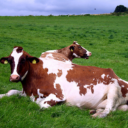

In [12]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

image_rt = reverse_transform(x_start.squeeze())
print(image_rt.size)

image_rt

In [13]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [14]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

torch.Size([1])
tensor([10])


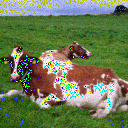

In [15]:
# take time step
t = torch.tensor([10])
print(t.shape)
print(t)
get_noisy_image(x_start, t)

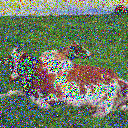

In [16]:
# take time step
t = torch.tensor([40])
get_noisy_image(x_start, t)

In [17]:
# use seed for reproducability
torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """
    Reference
    https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
    """
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [18]:
#plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])#CATS
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 20, 40, 60, 80]])#COWS

In [19]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## MedNIST dataset

In [51]:
dataDir = 'Medical-MNIST-Classification/resized'  # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

print(imageFilesList[1])



There are 58954 images in 6 distinct categories
Label names: ['Hand', 'ChestCT', 'CXR', 'AbdomenCT', 'BreastMRI', 'HeadCT']
Label counts: [10000, 10000, 10000, 10000, 8954, 10000]
Image dimensions: 64 x 64
Medical-MNIST-Classification/resized/Hand/009351.jpeg


In [59]:
image_size = 28

toTensor = torchvision.transforms.ToTensor()
toResize = torchvision.transforms.Resize(image_size)
toCenterCrop = torchvision.transforms.CenterCrop(image_size)
# toGraysacle = torchvision.transforms.Grayscale()

def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    y = toResize(y)
    y = toCenterCrop(y)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z

In [60]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print(type(imageTensor), type(classTensor))
print(imageTensor.shape)
print(classTensor.shape)
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([58954, 1, 28, 28])
torch.Size([58954])
Rescaled min pixel value = -0.79; Max = 0.979; Mean = -5.41e-11


In [74]:
BATCH_SIZE=128
BATCHES_SIZE=58954/BATCH_SIZE
dataloader = DataLoader(imageTensor, batch_size=BATCH_SIZE, shuffle=True)
print(f'BATCHES_SIZE {BATCHES_SIZE} or len(dataloader) {len(dataloader)}')


BATCHES_SIZE 460.578125 or len(dataloader) 461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 0; sampled images in the batch: 0 of 58954
    img.shape: torch.Size([128, 1, 28, 28])
    grid_img.shape: torch.Size([3, 482, 242])


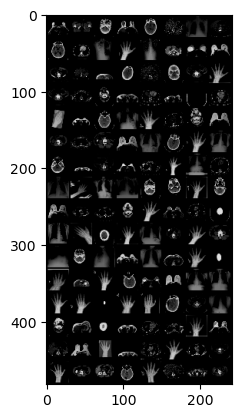

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 100; sampled images in the batch: 12800 of 58954
    img.shape: torch.Size([128, 1, 28, 28])
    grid_img.shape: torch.Size([3, 482, 242])


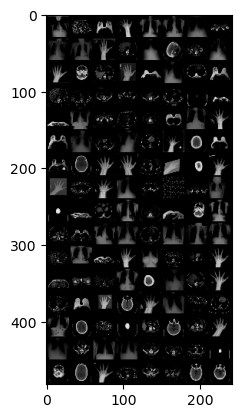

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 200; sampled images in the batch: 25600 of 58954
    img.shape: torch.Size([128, 1, 28, 28])
    grid_img.shape: torch.Size([3, 482, 242])


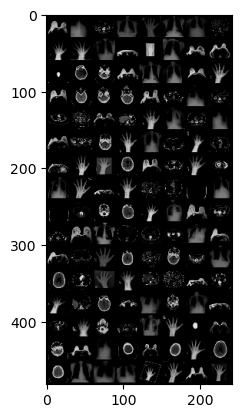

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 300; sampled images in the batch: 38400 of 58954
    img.shape: torch.Size([128, 1, 28, 28])
    grid_img.shape: torch.Size([3, 482, 242])


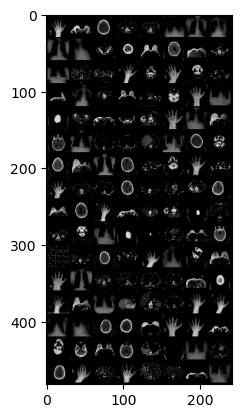

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 400; sampled images in the batch: 51200 of 58954
    img.shape: torch.Size([128, 1, 28, 28])
    grid_img.shape: torch.Size([3, 482, 242])


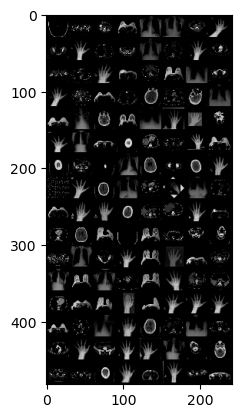

In [75]:
## Displaying dataloader content
len_dataloader = len(dataloader)

for batch_idx, batch in enumerate(dataloader):  #iterate through each batch    
    if batch_idx % 100 == 0:
        print(f'batch_idx: {batch_idx}; sampled images in the batch: { batch_idx*BATCH_SIZE } of {numTotal}')
        #print(batch.shape)
        img = batch
        print(f'    img.shape: {img.shape}') #torch.Size([BATCH_SIZE, 1, 64, 64])
        grid_img = torchvision.utils.make_grid(img) #also (img, nrow=10)
        print(f'    grid_img.shape: {grid_img.shape}')#torch.Size([3, 482, 242])
        plt.imshow(grid_img.permute(1, 2, 0)) 
        plt.show()
    

In [76]:
batch = next(iter(dataloader))
# print(batch.keys()) ## print(batch.keys())
print(batch.shape)


torch.Size([128, 1, 28, 28])


In [77]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        #imgs.append(img.cpu().numpy())
        imgs.append(img)
    return imgs

@torch.no_grad()
def sample_model(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [78]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000


In [79]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)


In [67]:
print(device)
# print(model)
# print(model.parameters())

cuda


In [80]:
from torchvision.utils import save_image

#time.time() is a bad idea because the system clock can be reset which will make you go back in time. 

# time.time_ns> Use time_ns() to avoid the precision loss caused by the float type.
# https://docs.python.org/3/library/time.html#time.time_ns


#time.monotonic() takes care of this (monotonic = it only goes forward)
# https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module

# time.monotonic(): For measurements on the order of hours/days, # you don't care about sub-second resolution 
# https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module


epochs = 20
batch_index_ratio=50
# 1 epoch takes around 86ish seconds

start_epoch_time = time.time()
for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    start_time = time.time()

    for batch_index, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch.shape[0] #128        
        batch = batch.to(device)
        #print(batch.shape)#torch.Size([128, 1, 28, 28])


        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        # print(t.shape)#128 > Random vector from 0 to batch_size

        loss = p_losses(model, batch, t, loss_type="huber")
        #print(type(loss))#<class 'torch.Tensor'>
        #print(loss.shape)##print(type(loss))#<class 'torch.Tensor'>
        #print(loss.item())#0.05364229766726494
        #print(loss)#tensor(0.0536, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

        if batch_index % batch_index_ratio == 0:
            print(f'   Loss: {loss.item()} at batch_index {batch_index} of {len_dataloader}')

        loss.backward()
        optimizer.step()

        # save generated images
        if batch_index != 0 and batch_index % save_and_sample_every == 0:
            milestone = batch_index // save_and_sample_every
            batches = num_to_groups(4, batch_size)
            all_images_list = list(map(lambda n: sample_model(model, batch_size=n, channels=channels), batches))
            all_images = torch.cat(all_images_list, dim=0)
            all_images = (all_images + 1) * 0.5
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
        
    elapsed_time = time.time() - start_time
    print(f'   Single Epoch loop elapsed_time {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))} (H:M:S)')
    
    
elapsed_epoch_time = time.time() - start_epoch_time
print(f'Total epoch loop elapsed_time_secs {elapsed_epoch_time}')
print(f'Total epoch loop {time.strftime("%H:%M:%S", time.gmtime(elapsed_epoch_time))} (H:M:S) ')

Epoch: 0
   Loss: 0.4783335328102112 at batch_index 0 of 461
   Loss: 0.20488522946834564 at batch_index 50 of 461
   Loss: 0.08161046355962753 at batch_index 100 of 461
   Loss: 0.06205228343605995 at batch_index 150 of 461
   Loss: 0.056316811591386795 at batch_index 200 of 461
   Loss: 0.04641734063625336 at batch_index 250 of 461
   Loss: 0.04042212292551994 at batch_index 300 of 461
   Loss: 0.048276305198669434 at batch_index 350 of 461
   Loss: 0.04463043808937073 at batch_index 400 of 461
   Loss: 0.041346266865730286 at batch_index 450 of 461
   Single Epoch loop elapsed_time_secs: 00:01:18
Epoch: 1
   Loss: 0.04774823039770126 at batch_index 0 of 461
   Loss: 0.038787633180618286 at batch_index 50 of 461
   Loss: 0.03504658490419388 at batch_index 100 of 461
   Loss: 0.04257027432322502 at batch_index 150 of 461
   Loss: 0.03773846849799156 at batch_index 200 of 461
   Loss: 0.049218788743019104 at batch_index 250 of 461
   Loss: 0.03108600340783596 at batch_index 300 of 461


   Loss: 0.023499993607401848 at batch_index 250 of 461
   Loss: 0.021554024890065193 at batch_index 300 of 461
   Loss: 0.025311147794127464 at batch_index 350 of 461
   Loss: 0.02191125974059105 at batch_index 400 of 461
   Loss: 0.02454059198498726 at batch_index 450 of 461
   Single Epoch loop elapsed_time_secs: 00:01:18
Epoch: 14
   Loss: 0.03573063760995865 at batch_index 0 of 461
   Loss: 0.02382981777191162 at batch_index 50 of 461
   Loss: 0.026580050587654114 at batch_index 100 of 461
   Loss: 0.027860498055815697 at batch_index 150 of 461
   Loss: 0.02258792705833912 at batch_index 200 of 461
   Loss: 0.02991284616291523 at batch_index 250 of 461
   Loss: 0.025051318109035492 at batch_index 300 of 461
   Loss: 0.033381007611751556 at batch_index 350 of 461
   Loss: 0.01979438029229641 at batch_index 400 of 461
   Loss: 0.02504551038146019 at batch_index 450 of 461
   Single Epoch loop elapsed_time_secs: 00:01:18
Epoch: 15
   Loss: 0.024389469996094704 at batch_index 0 of 461

In [81]:
# sample BATCH_SIZE images
BATCH_SIZE = 32
samples = sample_model(model, image_size=image_size, batch_size=BATCH_SIZE, channels=channels)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [82]:
print(type(samples)) #<class 'list'>
print(f'len(samples): {len(samples)}') #len(samples): 200?
print(samples[0].shape) #torch.Size([500, 1, 28, 28])


<class 'list'>
len(samples): 200
torch.Size([32, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 0


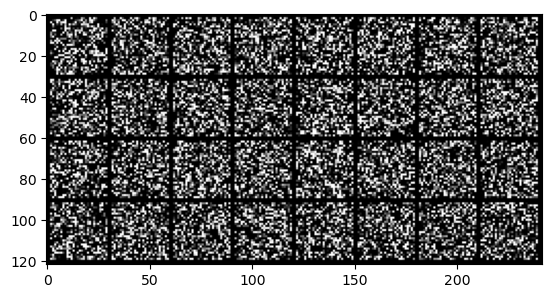

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 20


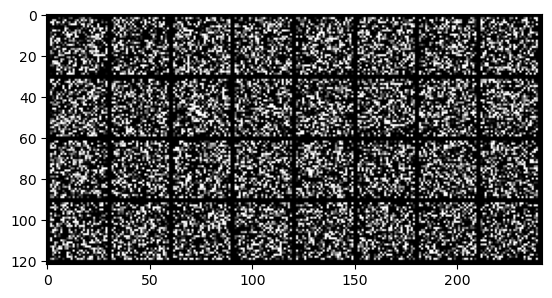

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 40


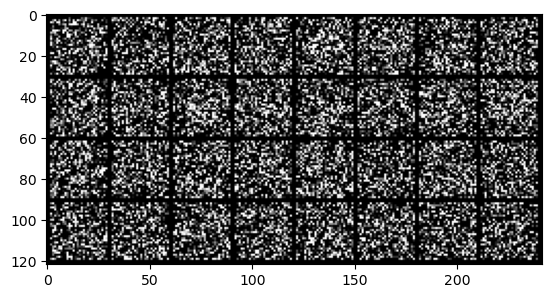

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 60


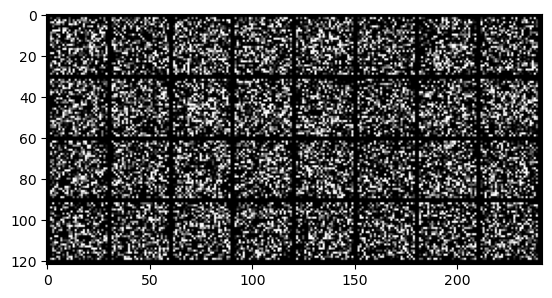

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 80


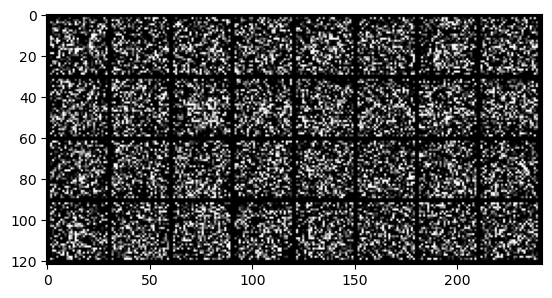

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 100


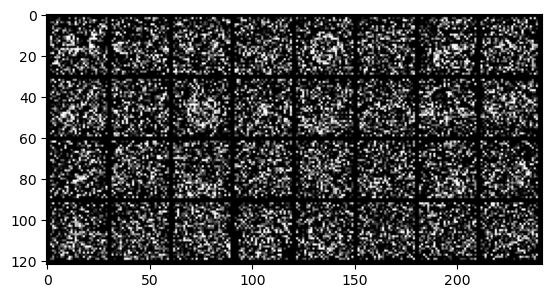

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 120


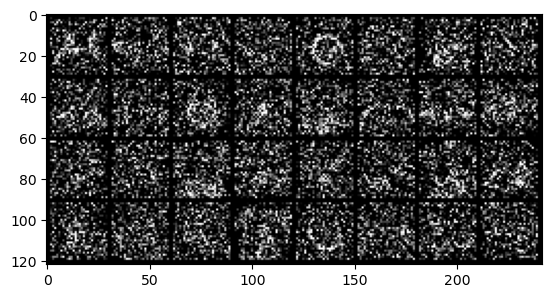

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 140


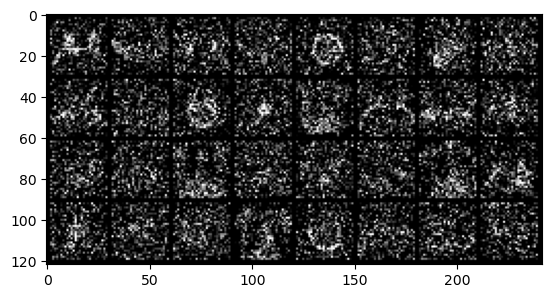

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 160


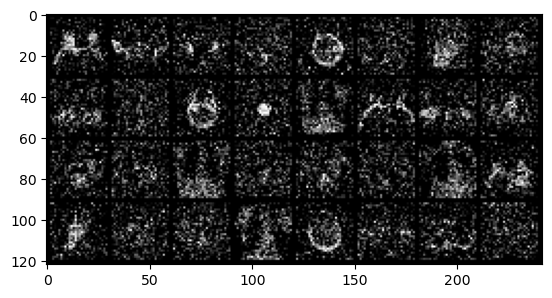

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 180


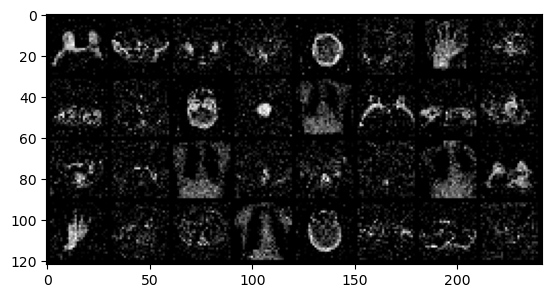

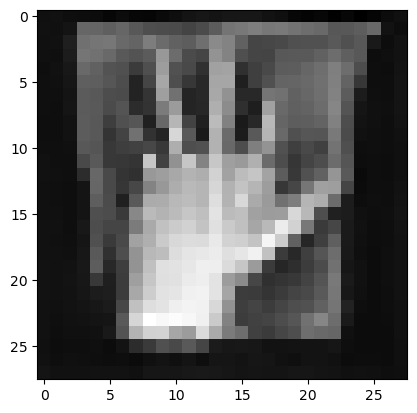

In [85]:
## show a batches 
for samples_idx, samples_img in enumerate(samples):    
    if samples_idx % 20 == 0:
        print(f'samples_idx: {samples_idx}')
        #print(f'samples_img.shape: {samples_img.shape}') #torch.Size([64, 1, 28, 28])
        grid_img = torchvision.utils.make_grid(samples_img)
        #grid_img = torchvision.utils.make_grid(samples_img, nrow=30)
        #print(f'grid_img.shape: {grid_img.shape}') #torch.Size([3, 122, 602])
        plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy()) #.numpy().astype("uint8")) 
        plt.show()


## show a random one
random_index = 6
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels).cpu().numpy(), cmap="gray")
plt.show()


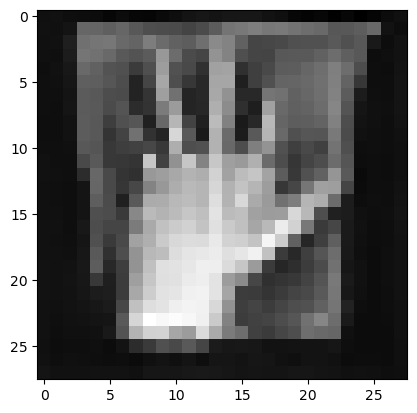

In [86]:
import matplotlib.animation as animation
from IPython.display import HTML #for HTML(animation.ArtistAnimation().to_jshtml())

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels).cpu().numpy(), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
HTML(animate.to_jshtml())      


In [ ]:
mycwd = os.getcwd()
print(mycwd)
os.chdir("..") #Cheange to previous directory
results_path = os.getcwd()+'/results'
os.chdir(results_path)

In [31]:
##Save animation
animate.save('medNIST.gif', writer='imagemagick', fps=60)

In [33]:
torch.save(model, 'saved_medNIST_model')

In [89]:
ls -la

total 8
drwxrwxr-x 2 mxochicale mxochicale 4096 Dec 27 00:51 ./
drwxrwxr-x 5 mxochicale mxochicale 4096 Dec 27 14:44 ../


In [ ]:
os.chdir(mycwd)     # go back where you came from